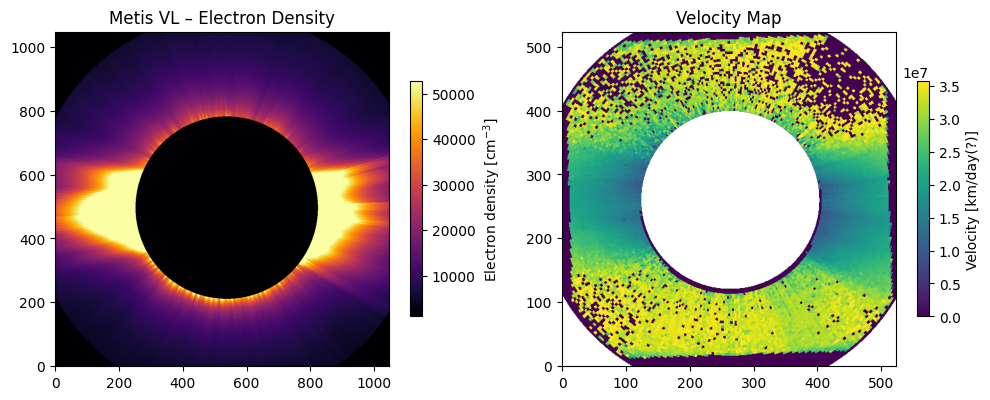

In [1]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np

# -----------------------------
# --- Step 1: Load FITS data ---
# -----------------------------

# Paths to FITS files
density_fits  = "data/solo_L2_metis-vl-pb_20210114T003001_V01_1_0.71_ne.fits"
velocity_fits = "data/ddt_ws_20210114T004530_Gi_10_100_1.fits"

# Open electron density FITS
with fits.open(density_fits) as hdul_den:
    den_data = hdul_den[0].data
    den_header = hdul_den[0].header

# Open velocity FITS
with fits.open(velocity_fits) as hdul_vel:
    vel_data = hdul_vel[0].data
    vel_header = hdul_vel[0].header

# Create side-by-side plots
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

# Electron density plot
im0 = axes[0].imshow(
    den_data,
    origin="lower",
    cmap="inferno",
    vmin=np.nanpercentile(den_data, 5),
    vmax=np.nanpercentile(den_data, 95)
)
axes[0].set_title("Metis VL – Electron Density")
cbar0 = plt.colorbar(im0, ax=axes[0], shrink=0.5)
cbar0.set_label("Electron density [cm$^{-3}$]")

# Velocity map plot
im1 = axes[1].imshow(
    vel_data,
    origin="lower",
    cmap="viridis",
    vmin=np.nanpercentile(vel_data, 5),
    vmax=np.nanpercentile(vel_data, 95)
)
axes[1].set_title("Velocity Map")
cbar1 = plt.colorbar(im1, ax=axes[1], shrink=0.5)
cbar1.set_label("Velocity [km/day(?)]")

plt.tight_layout()
plt.show()

In [2]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
from scipy.ndimage import zoom, map_coordinates, shift
import sys
import os
from astropy.stats import sigma_clip

# -------------------------------------------------
# --- Latitude range ------------------------------
# -------------------------------------------------
latitude_min  = 0.  # [deg]
latitude_max  = 91.  # [deg]
latitude_step = 90.   # [deg]

lat_obs_vec = []
r_obs_vec   = []
ne_obs_vec  = []
u_obs_vec   = []

print("Considered latitudes:")
for latitude_val in np.arange(latitude_min, latitude_max, latitude_step):

    print("--"*10)
    print(f"Latitude: {latitude_val} deg")

    # -------------------------------------------------
    # --- Step 2: Resize & shift density map ----------
    # -------------------------------------------------
    zoom_y = vel_data.shape[0] / den_data.shape[0]
    zoom_x = vel_data.shape[1] / den_data.shape[1]
    den_data_resized = zoom(den_data, (zoom_y, zoom_x), order=1)

    cx_den_resized = den_header["SUN_XCEN"] * zoom_x
    cy_den_resized = den_header["SUN_YCEN"] * zoom_y
    cx_vel, cy_vel = vel_header["XCEN"], vel_header["YCEN"]

    shift_x = cx_vel - cx_den_resized
    shift_y = cy_vel - cy_den_resized
    den_data_resized = shift(den_data_resized, shift=(shift_y, shift_x), order=1)

    cx_den_resized += shift_x
    cy_den_resized += shift_y

    if not (cx_den_resized == cx_vel and cy_den_resized == cy_vel):
        sys.exit("ATTENTION! Images not aligned!")

    print("Images resized & Sun-center aligned!")

    # -------------------------------------------------
    # --- Occulter & annulus --------------------------
    # -------------------------------------------------
    io_cx, io_cy = den_header["IO_XCEN"], den_header["IO_YCEN"]
    r_inner, r_outer = 300, 500  # pixels (original density)

    io_cx_resized = io_cx * zoom_x + shift_x
    io_cy_resized = io_cy * zoom_y + shift_y
    r_inner_resized = r_inner * zoom_x
    r_outer_resized = r_outer * zoom_x

    def annular_mask(shape, cx, cy, r_in, r_out):
        y, x = np.indices(shape)
        r = np.sqrt((x - cx)**2 + (y - cy)**2)
        return (r >= r_in) & (r <= r_out)

    mask_den = annular_mask(den_data_resized.shape, io_cx_resized, io_cy_resized,
                            r_inner_resized, r_outer_resized)
    mask_vel = annular_mask(vel_data.shape, io_cx_resized, io_cy_resized,
                            r_inner_resized, r_outer_resized)

    den_data_masked = np.where(mask_den, den_data_resized, np.nan)
    vel_data_masked = np.where(mask_vel, vel_data, np.nan)

    # -------------------------------------------------
    # --- Radial extraction ---------------------------
    # -------------------------------------------------
    def radial_from_center(data, cx, cy, start_radius=0, angle_deg=0):
        theta = np.deg2rad(angle_deg)
        
        dx_pos = (data.shape[1]-1 - cx) / np.cos(theta) if np.cos(theta) > 0 else np.inf
        dx_neg = -cx / np.cos(theta) if np.cos(theta) < 0 else np.inf
        dy_pos = (data.shape[0]-1 - cy) / np.sin(theta) if np.sin(theta) > 0 else np.inf
        dy_neg = -cy / np.sin(theta) if np.sin(theta) < 0 else np.inf
        max_radius = int(np.floor(min(dx_pos, dx_neg, dy_pos, dy_neg)))
        
        r_vals = np.arange(start_radius, max_radius)
        x = cx + r_vals * np.cos(theta)
        y = cy + r_vals * np.sin(theta)
        radial = map_coordinates(data, [y, x], order=1, mode='nearest')
        return r_vals, radial


    angle_deg = latitude_val

    r_den, radial_den = radial_from_center(den_data_masked, cx_den_resized, cy_den_resized,
                                           start_radius=r_inner_resized,
                                           angle_deg=angle_deg)

    r_vel, radial_vel = radial_from_center(vel_data_masked, cx_vel, cy_vel,
                                           start_radius=r_inner_resized,
                                           angle_deg=angle_deg)

    # -------------------------------------------------
    # --- Pixel → Rsun --------------------------------
    # -------------------------------------------------
    Rsun_pixels_den = den_header["RSUN"] * zoom_x
    Rsun_pixels_vel = vel_header["RSUN"]

    h_den_Rsun = r_den / Rsun_pixels_den - 1
    h_vel_Rsun = r_vel / Rsun_pixels_vel - 1

    # -------------------------------------------------
    # --- Step 6: ROBUST observed point ----------------
    # -------------------------------------------------
    delta_r = 0.25  # [Rsun]

    r_inner_Rsun = (r_inner * zoom_x / Rsun_pixels_den) - 1
    r_outer_Rsun = (r_outer * zoom_x / Rsun_pixels_den) - 1
    r_target = 0.5 * (r_inner_Rsun + r_outer_Rsun)

    # --- Density (robust)
    mask_den_r = np.abs(h_den_Rsun - r_target) < delta_r
    ne_slice = radial_den[mask_den_r]
    ne_slice = ne_slice[np.isfinite(ne_slice) & (ne_slice > 0)]

    if len(ne_slice) < 3:
        ne_obs = np.nan
        print("WARNING: too few density points")
    else:
        ne_clip = sigma_clip(ne_slice, sigma=3, maxiters=5)
        ne_obs = np.nanmedian(ne_clip)

    # --- Velocity (robust)
    mask_vel_r = np.abs(h_vel_Rsun - r_target) < delta_r
    u_slice = radial_vel[mask_vel_r]
    u_slice = u_slice[np.isfinite(u_slice) & (u_slice > 0)]

    if len(u_slice) < 3:
        u_obs = np.nan
        print("WARNING: too few velocity points")
    else:
        u_clip = sigma_clip(u_slice, sigma=3, maxiters=5)
        u_obs = np.nanmedian(u_clip)

    r_obs = r_target

    print(f"r_obs={r_obs:.2f} Rsun | ne_obs={ne_obs:.2e} | u_obs={u_obs:.2e}")

    # -------------------------------------------------
    # --- Step 7: Plots --------------------------------
    # -------------------------------------------------
    output_dir = "output"
    os.makedirs(output_dir, exist_ok=True)

    fig, axes = plt.subplots(2, 2, figsize=(14, 12))

    # Density map
    im0 = axes[0,0].imshow(den_data_masked, origin='lower', cmap='inferno')
    axes[0,0].scatter(cx_den_resized, cy_den_resized,
                      facecolors='none', edgecolors='green',
                      s=80, linewidths=2, label='Sun center')
    axes[0,0].plot(cx_den_resized + r_den*np.cos(np.deg2rad(angle_deg)),
                   cy_den_resized + r_den*np.sin(np.deg2rad(angle_deg)),
                   '--', color='cyan', label='Radial')
    axes[0,0].set_title("Electron Density map")
    axes[0,0].set_xlabel("Pixel")
    axes[0,0].set_ylabel("Pixel")
    fig.colorbar(im0, ax=axes[0,0], shrink=0.8, label=r"n$_e$ [cm$^{-3}$]")
    axes[0,0].legend()

    # Velocity map
    im1 = axes[0,1].imshow(vel_data_masked, origin='lower', cmap='viridis')
    axes[0,1].scatter(cx_vel, cy_vel,
                      facecolors='none', edgecolors='green',
                      s=80, linewidths=2, label='Sun center')
    axes[0,1].plot(cx_vel + r_vel*np.cos(np.deg2rad(angle_deg)),
                   cy_vel + r_vel*np.sin(np.deg2rad(angle_deg)),
                   '--', color='cyan', label='Radial')
    axes[0,1].set_title("Velocity map")
    axes[0,1].set_xlabel("Pixel")
    axes[0,1].set_ylabel("Pixel")
    fig.colorbar(im1, ax=axes[0,1], shrink=0.8, label="v [cm/s]")
    axes[0,1].legend()

    # Density radial
    axes[1,0].plot(h_den_Rsun, radial_den, '.', label='Radial profile')
    axes[1,0].axvspan(r_target-delta_r, r_target+delta_r,
                      color='orange', alpha=0.25, label=r'$\Delta r$ window')
    axes[1,0].plot(r_obs, ne_obs, 'o', color='red', label='Robust $n_e$')
    axes[1,0].set_xlabel("Distance from solar surface [R$_sun$]")
    axes[1,0].set_ylabel(r"n$_e$ [cm$^{-3}$]")
    axes[1,0].grid(ls='--', alpha=0.4)
    axes[1,0].legend()

    # Velocity radial
    axes[1,1].plot(h_vel_Rsun, radial_vel, '.', label='Radial profile')
    axes[1,1].axvspan(r_target-delta_r, r_target+delta_r,
                      color='orange', alpha=0.25, label=r'$\Delta r$ window')
    axes[1,1].plot(r_obs, u_obs, 'o', color='red', label='Robust $u$')
    axes[1,1].set_xlabel("Distance from solar surface [R$_sun$]")
    axes[1,1].set_ylabel("Velocity [cm/s]")
    axes[1,1].grid(ls='--', alpha=0.4)
    axes[1,1].legend()

    plt.tight_layout()
    outfile = f"{output_dir}/lat_{latitude_val:.1f}deg.png"
    plt.savefig(outfile, dpi=300)
    plt.close()

    print(f"Figure saved: {outfile}")

    # -------------------------------------------------
    # --- Save values ---------------------------------
    # -------------------------------------------------
    lat_obs_vec.append(np.deg2rad(angle_deg))
    r_obs_vec.append(r_obs)
    ne_obs_vec.append(ne_obs)
    u_obs_vec.append(u_obs)

print("--"*10)

Considered latitudes:
--------------------
Latitude: 0.0 deg
Images resized & Sun-center aligned!
r_obs=4.13 Rsun | ne_obs=5.33e+04 | u_obs=1.81e+07


/Users/aliberatore/miniforge3/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:868: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/aliberatore/miniforge3/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:868: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Figure saved: output/lat_0.0deg.png
--------------------
Latitude: 90.0 deg
Images resized & Sun-center aligned!
r_obs=4.13 Rsun | ne_obs=1.24e+04 | u_obs=3.08e+07


/Users/aliberatore/miniforge3/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:868: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)
/Users/aliberatore/miniforge3/lib/python3.12/site-packages/numpy/_core/fromnumeric.py:868: UserWarning: Warning: 'partition' will ignore the 'mask' of the MaskedArray.
  a.partition(kth, axis=axis, kind=kind, order=order)


Figure saved: output/lat_90.0deg.png
--------------------


In [3]:
# Different latitudes ---------------------------------------------
latitude = lat_obs_vec  # [deg]

# Different height above photosphere ------------------------------
height = r_obs_vec      # [Rsun]

# Electron density at different latitudes -------------------------
nE = ne_obs_vec         # [cm^-3]

# Solar wind at different latitudes -------------------------------
uE = u_obs_vec          # [cm/s]

In [4]:
from sympy import *
import sympy as sp

r = symbols('r')      # radial distance
phi = symbols('phi')  # latitude

In [5]:
h_values = np.linspace(0.01, 10, 1000)  # altitude above photosphere in solar radius unit

ne = []
ne_values = []
for lat in range(len(latitude)):
    ne_singleLat = 10**8 * (3.09 * r**(-16) * (1 - 0.5 * sin(phi)) 
         + 1.58 * r**(-6) * (1 - 0.95 * sin(phi))
         + 0.0251 * r**(-2.5) * (1 - sqrt(sin(phi)))) + nE[lat] * (height[lat]/r)**2
    ne.append(ne_singleLat.subs(phi, latitude[lat]))
    ne_values.append([ne[lat].subs(r, h+1) for h in h_values])
    #print("ne_values[{0}]:\n{1}\n".format(lat, ne_values[lat]))
print("ne:", ne)

ne: [2510000.0/r**2.5 + 910494.605667761/r**2 + 158000000.0/r**6 + 309000000.0/r**16, 212631.751472847/r**2 + 7900000.00000001/r**6 + 154500000.0/r**16]


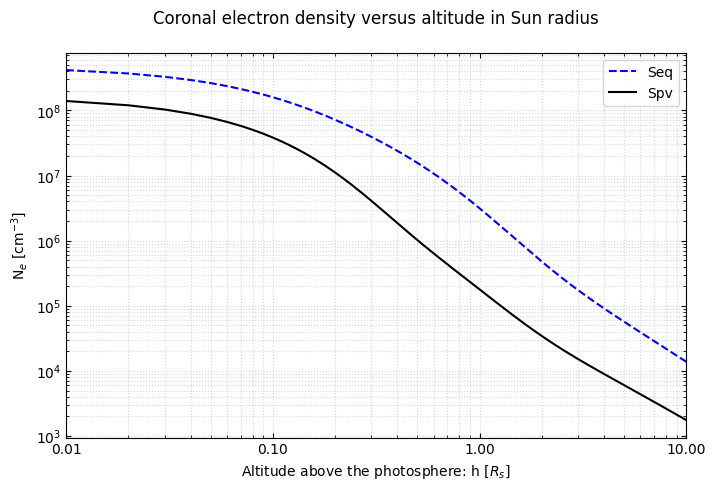

In [6]:
from matplotlib.ticker import ScalarFormatter

plt.figure(figsize=(8, 5))

# Plot
plt.plot(h_values, ne_values[0], "--", label='Seq', color = "blue")
plt.plot(h_values, ne_values[1], "-", label='Spv', color = "black")

# Cosmetic
plt.title("Coronal electron density versus altitude in Sun radius\n")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("Altitude above the photosphere: h [$R_s$]")
plt.ylabel("N$_e$ [cm$^{-3}$]")
plt.tick_params(direction="in", which="both", top = "True", right = "True")
plt.grid(True, which="both", linestyle=":", alpha = 0.5)

ax = plt.gca()
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.ticklabel_format(useOffset=False, style='plain', axis='x')

plt.xlim(0.01,10)

# Legend
plt.legend()
plt.rcParams['figure.dpi'] = 600  # set the image resolution at 600 DPI

In [7]:
u = []
u_values = []

for lat in range(len(latitude)):
    AE_Ar = (height[lat]/r)**2
    u_singleLat = uE[lat] * AE_Ar * nE[lat] / ne[lat]
    #print(r'u_singleLat:', u_singleLat)
    u.append(u_singleLat.subs(phi, latitude[lat]))
    #print("u:", u)
    u_values.append([u[lat].subs(r, h+1) for h in h_values])
    #print("u_values[{0}]:\n{1}\n".format(lat, u_values[lat]))

In [8]:
du_dr = []
du_dr_values = []

for lat in range(len(latitude)):
    du_dr_singleLat = sp.diff(u[lat], r)
    du_dr.append(du_dr_singleLat)
    du_dr_values.append([du_dr[lat].subs(r, h+1) for h in h_values])
    #print("du/dr_values[{0}]:\n{1}\n".format(lat, du_dr_values[lat]))

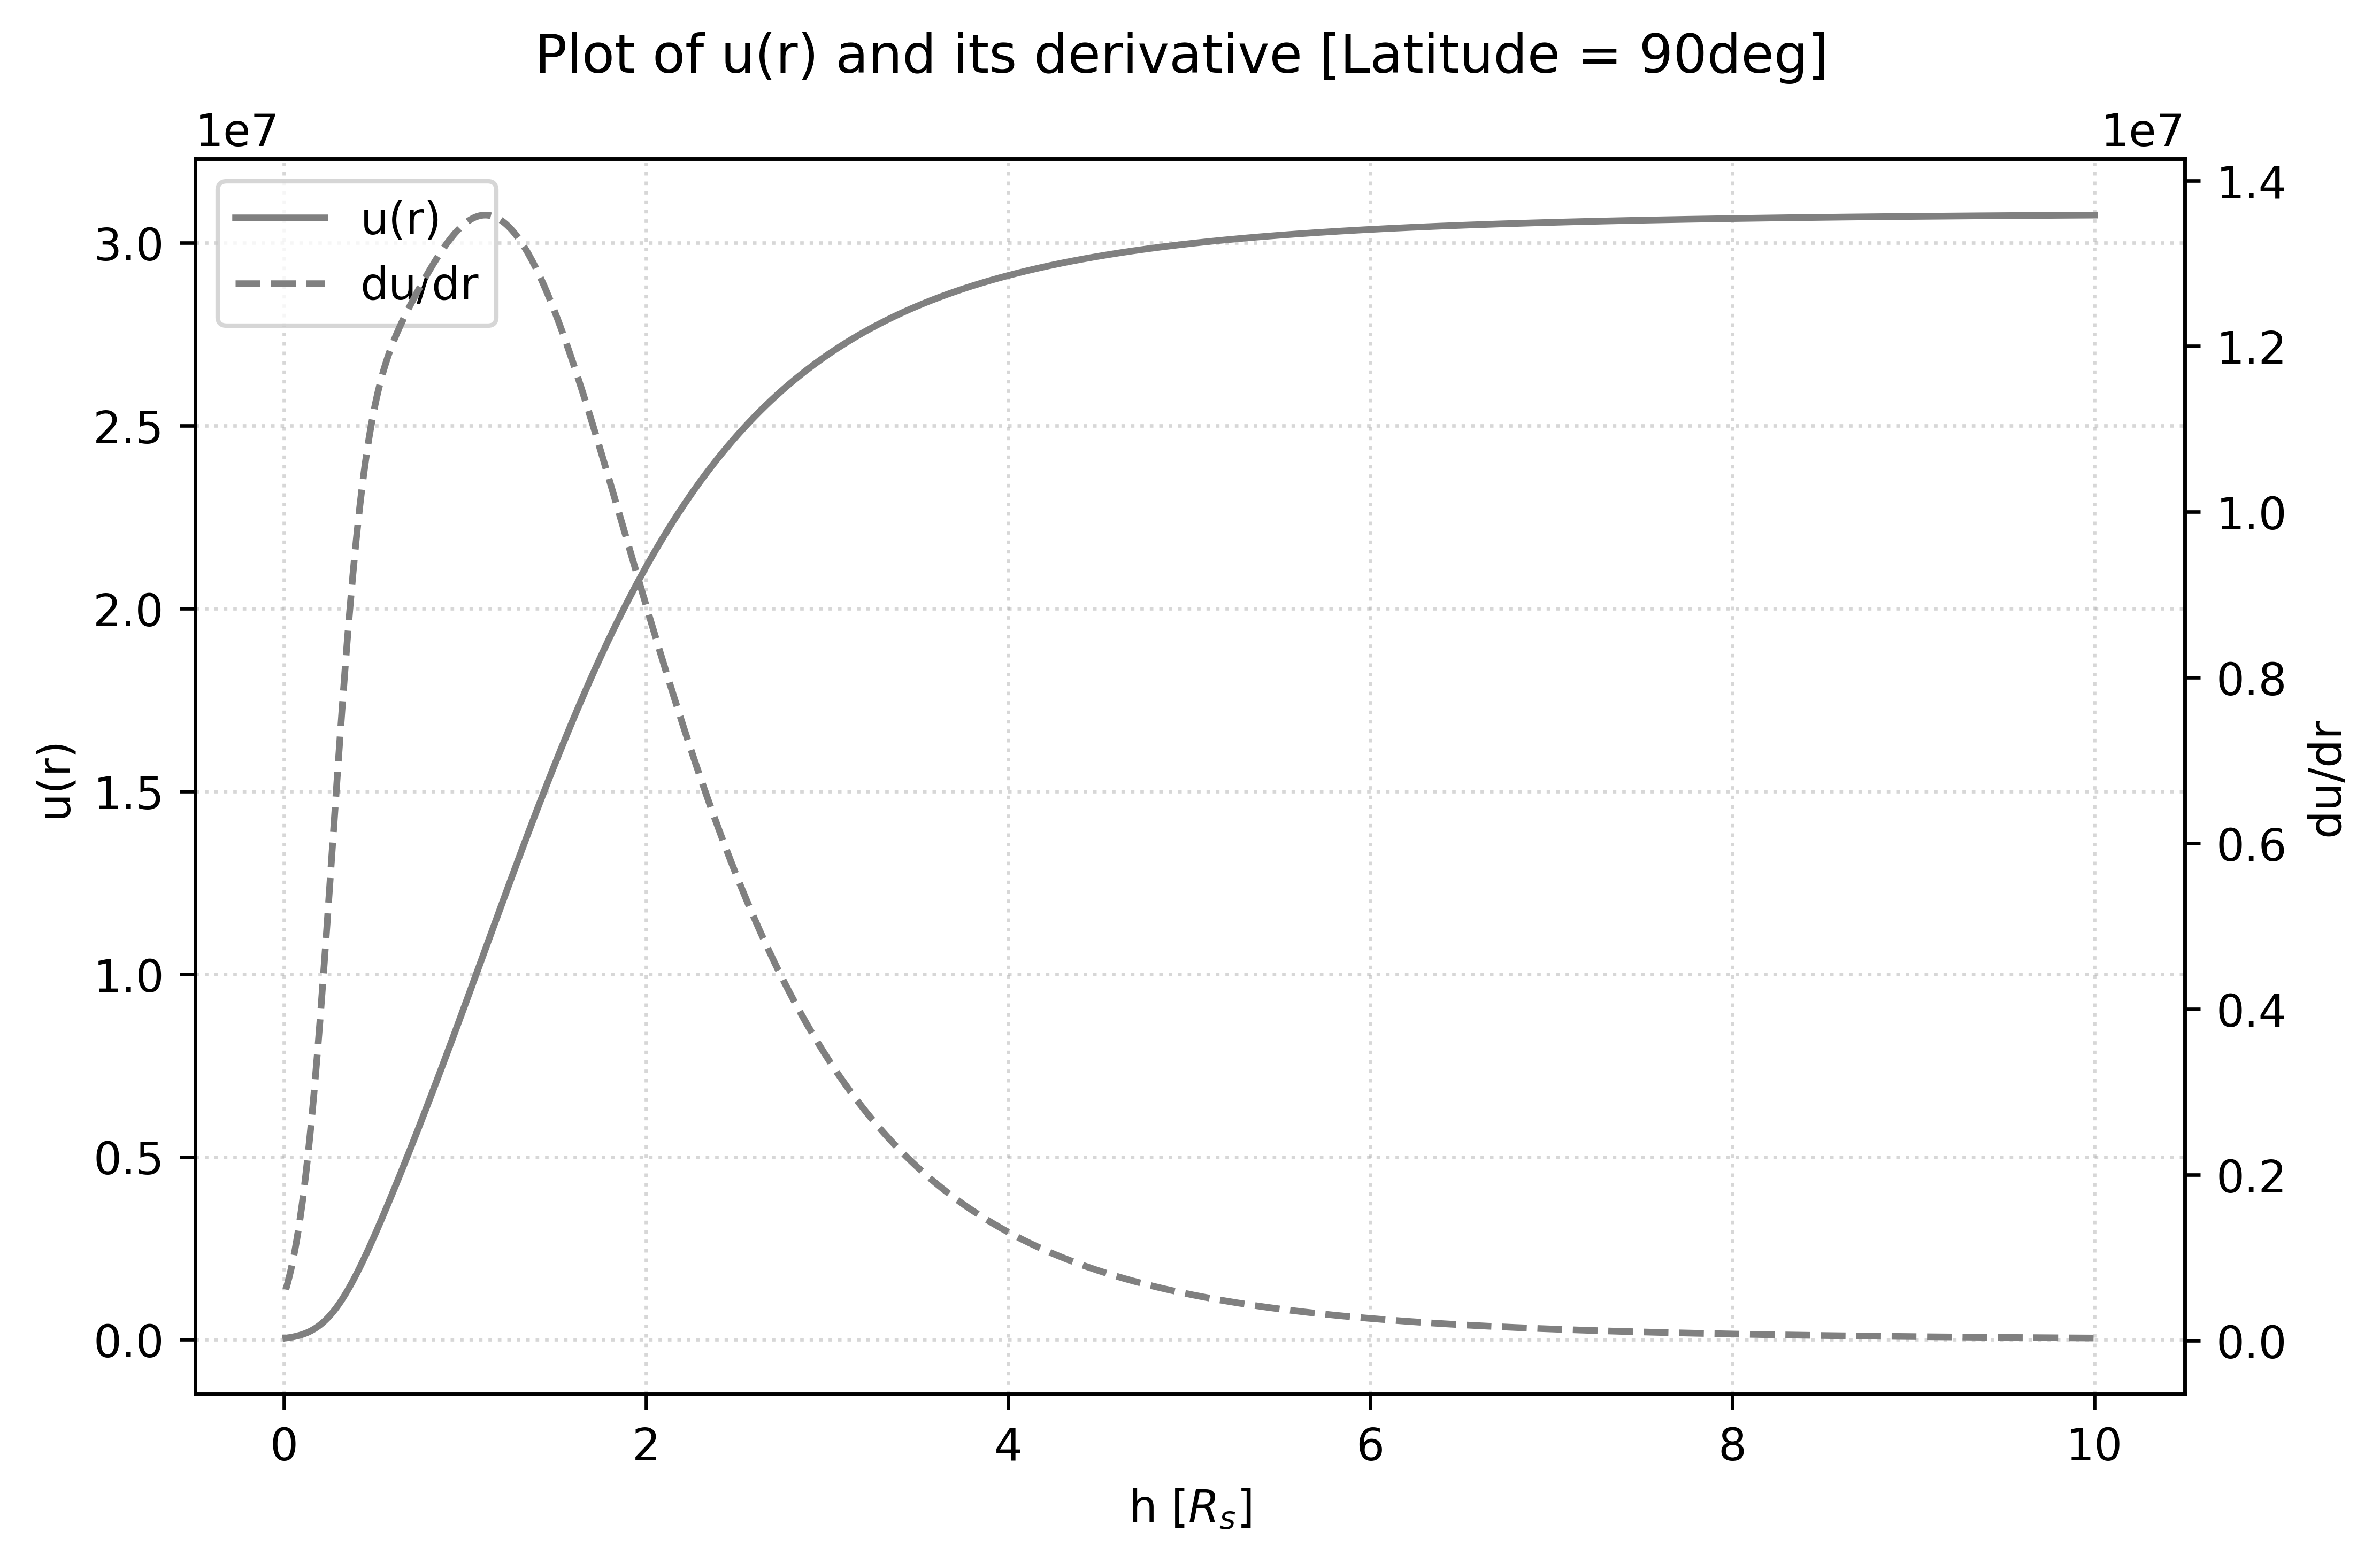

In [9]:
# E.g., plot of u(r) with polar values, and its derivative
fig, ax1 = plt.subplots(figsize=(8, 5))

# Plot
line1, = ax1.plot(h_values, u_values[1], "-", label='u(r)', color = "gray")
ax2 = ax1.twinx()
line2, = ax2.plot(h_values, du_dr_values[1], "--", label='du/dr', color = "gray")

ax1.set_xlabel('h [$R_s$]')
ax1.set_ylabel('u(r)')
ax2.set_ylabel('du/dr')

ax1.set_title('Plot of u(r) and its derivative [Latitude = 90deg] \n')
ax1.grid(True, which="both", linestyle=":", alpha = 0.5)
#ax2.grid(True, which="both", linestyle=":", alpha = 0.5)

lines = [line1, line2]
ax1.legend(lines, [line.get_label() for line in lines], loc='upper left')
plt.rcParams['figure.dpi'] = 600  # set the image resolution at 600 DPI

In [10]:
gS = 2.74e4  # [cm/s^2]

In [11]:
from astropy.constants import R_sun
from astropy import units

Rsun_cm = R_sun.to(units.cm).value  # Solar radius in centimeters (float)

F = []
F_values = []

for lat in range(len(latitude)):
    F_singleLat = (1 / (gS * Rsun_cm)) * r**2 * u[lat] * du_dr[lat]
    F.append(F_singleLat)
    F_values.append([F[lat].subs(r, h+1) for h in h_values])
    #print("F_values[{0}]:\n{1}\n".format(lat, F_values[lat]))

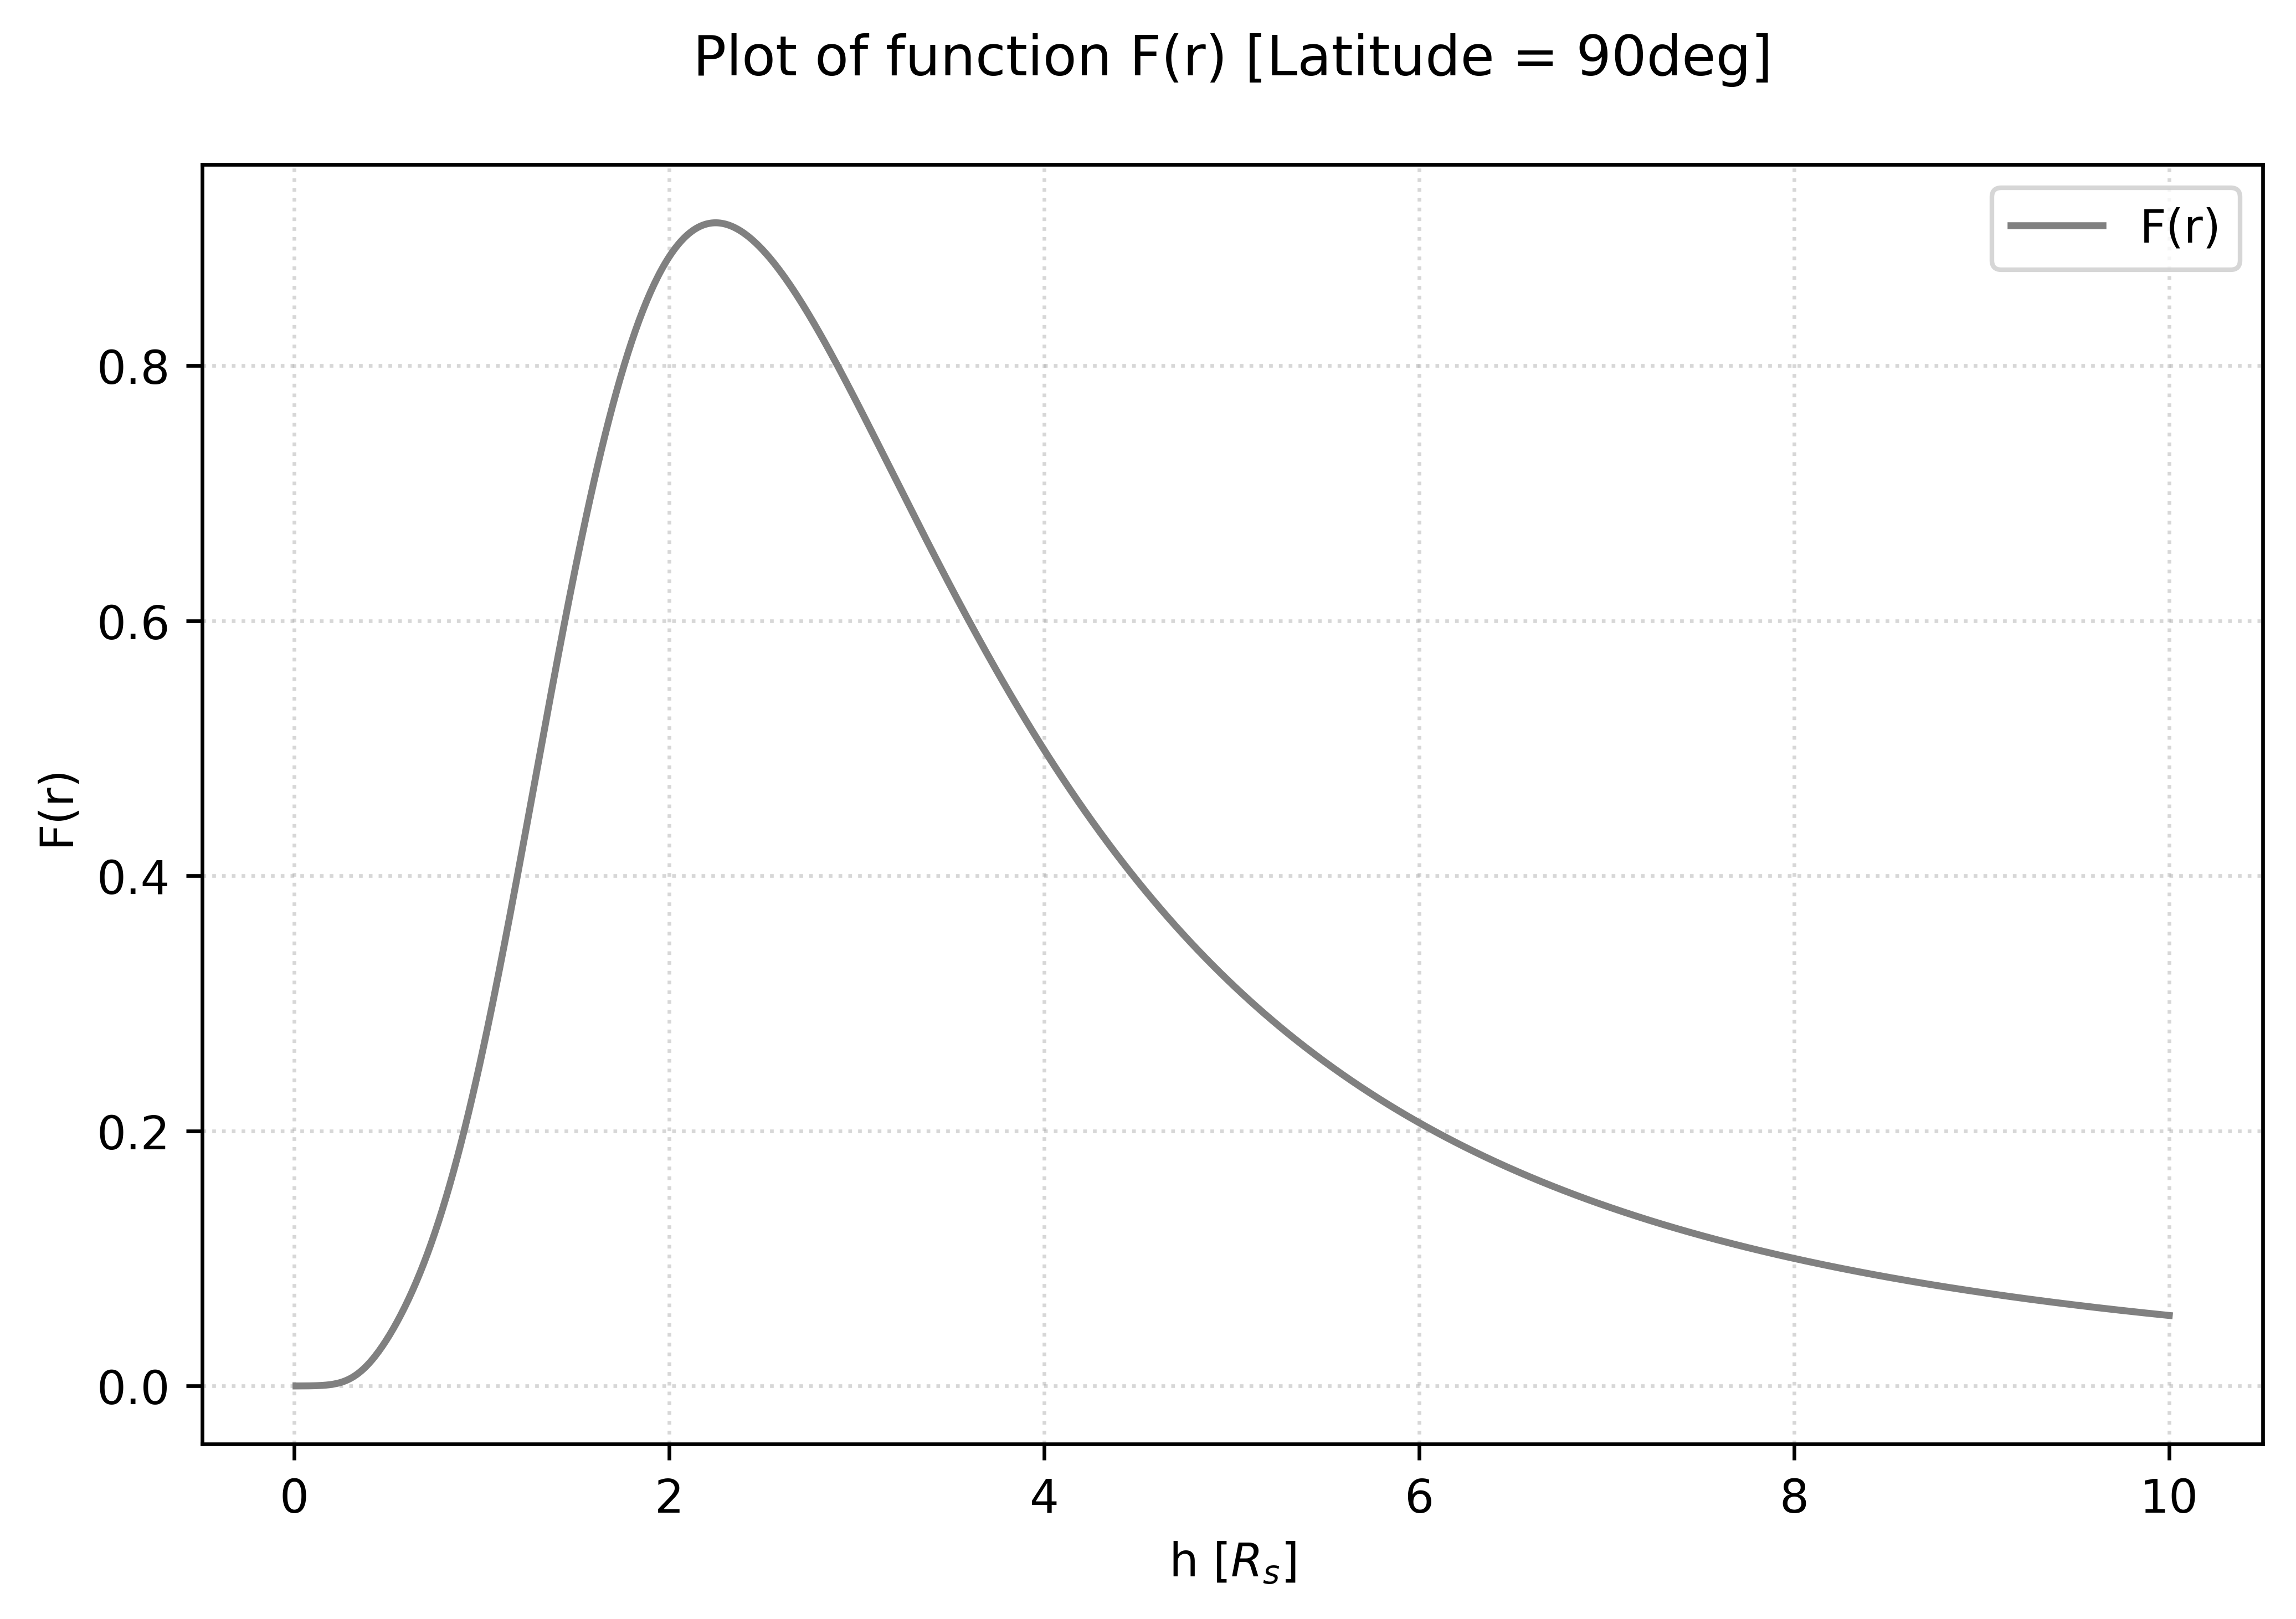

In [18]:
# E.g., plot of F(r) with polar values
fig, ax1 = plt.subplots(figsize=(8, 5))

ax1.plot(h_values, F_values[1], "-", label='F(r)', color = "gray")

ax1.set_xlabel('h [$R_s$]')
ax1.set_ylabel('F(r)')

ax1.set_title('Plot of function F(r) [Latitude = 90deg]\n')
ax1.grid(True, which="both", linestyle=":", alpha = 0.5)
ax1.legend()
plt.rcParams['figure.dpi'] = 600  # set the image resolution at 600 DPI

In [13]:
# Normalization temperature

mu = 0.5           # Ratio mi/mp (if the gas is fully ionized hydrogen) [see Page 6 of 25 in REF_1]
mH = 1.67e-27      # Mass of hydrogen atom [kg]
kb = 1.380649e-19  # Boltzmann constant [cm^2 kg / s^2 K]

T_star = mu*gS*Rsun_cm*mH/kb  # = 1.15e+07 K
#T_star = 13e6  # K [i.e., Ref_1]
#T_star = 17e6  # K [i.e., Ref_2]
print("T* = {0:.2e} K".format(T_star))

T* = 1.15e+07 K


In [14]:
from scipy.integrate import quad
from mpmath import quad, inf

T_differentLat = []

for lat in range(len(latitude)):

    integrand = (ne[lat] / r**2) * (1 + F[lat])
    func = sp.lambdify(r, integrand, modules='scipy')
    T_singleLat = [-float(quad(func, [inf, r_extreme+1])) * T_star/float(ne[lat].subs(r,r_extreme+1)) for r_extreme in h_values]

    T_differentLat.append(T_singleLat)

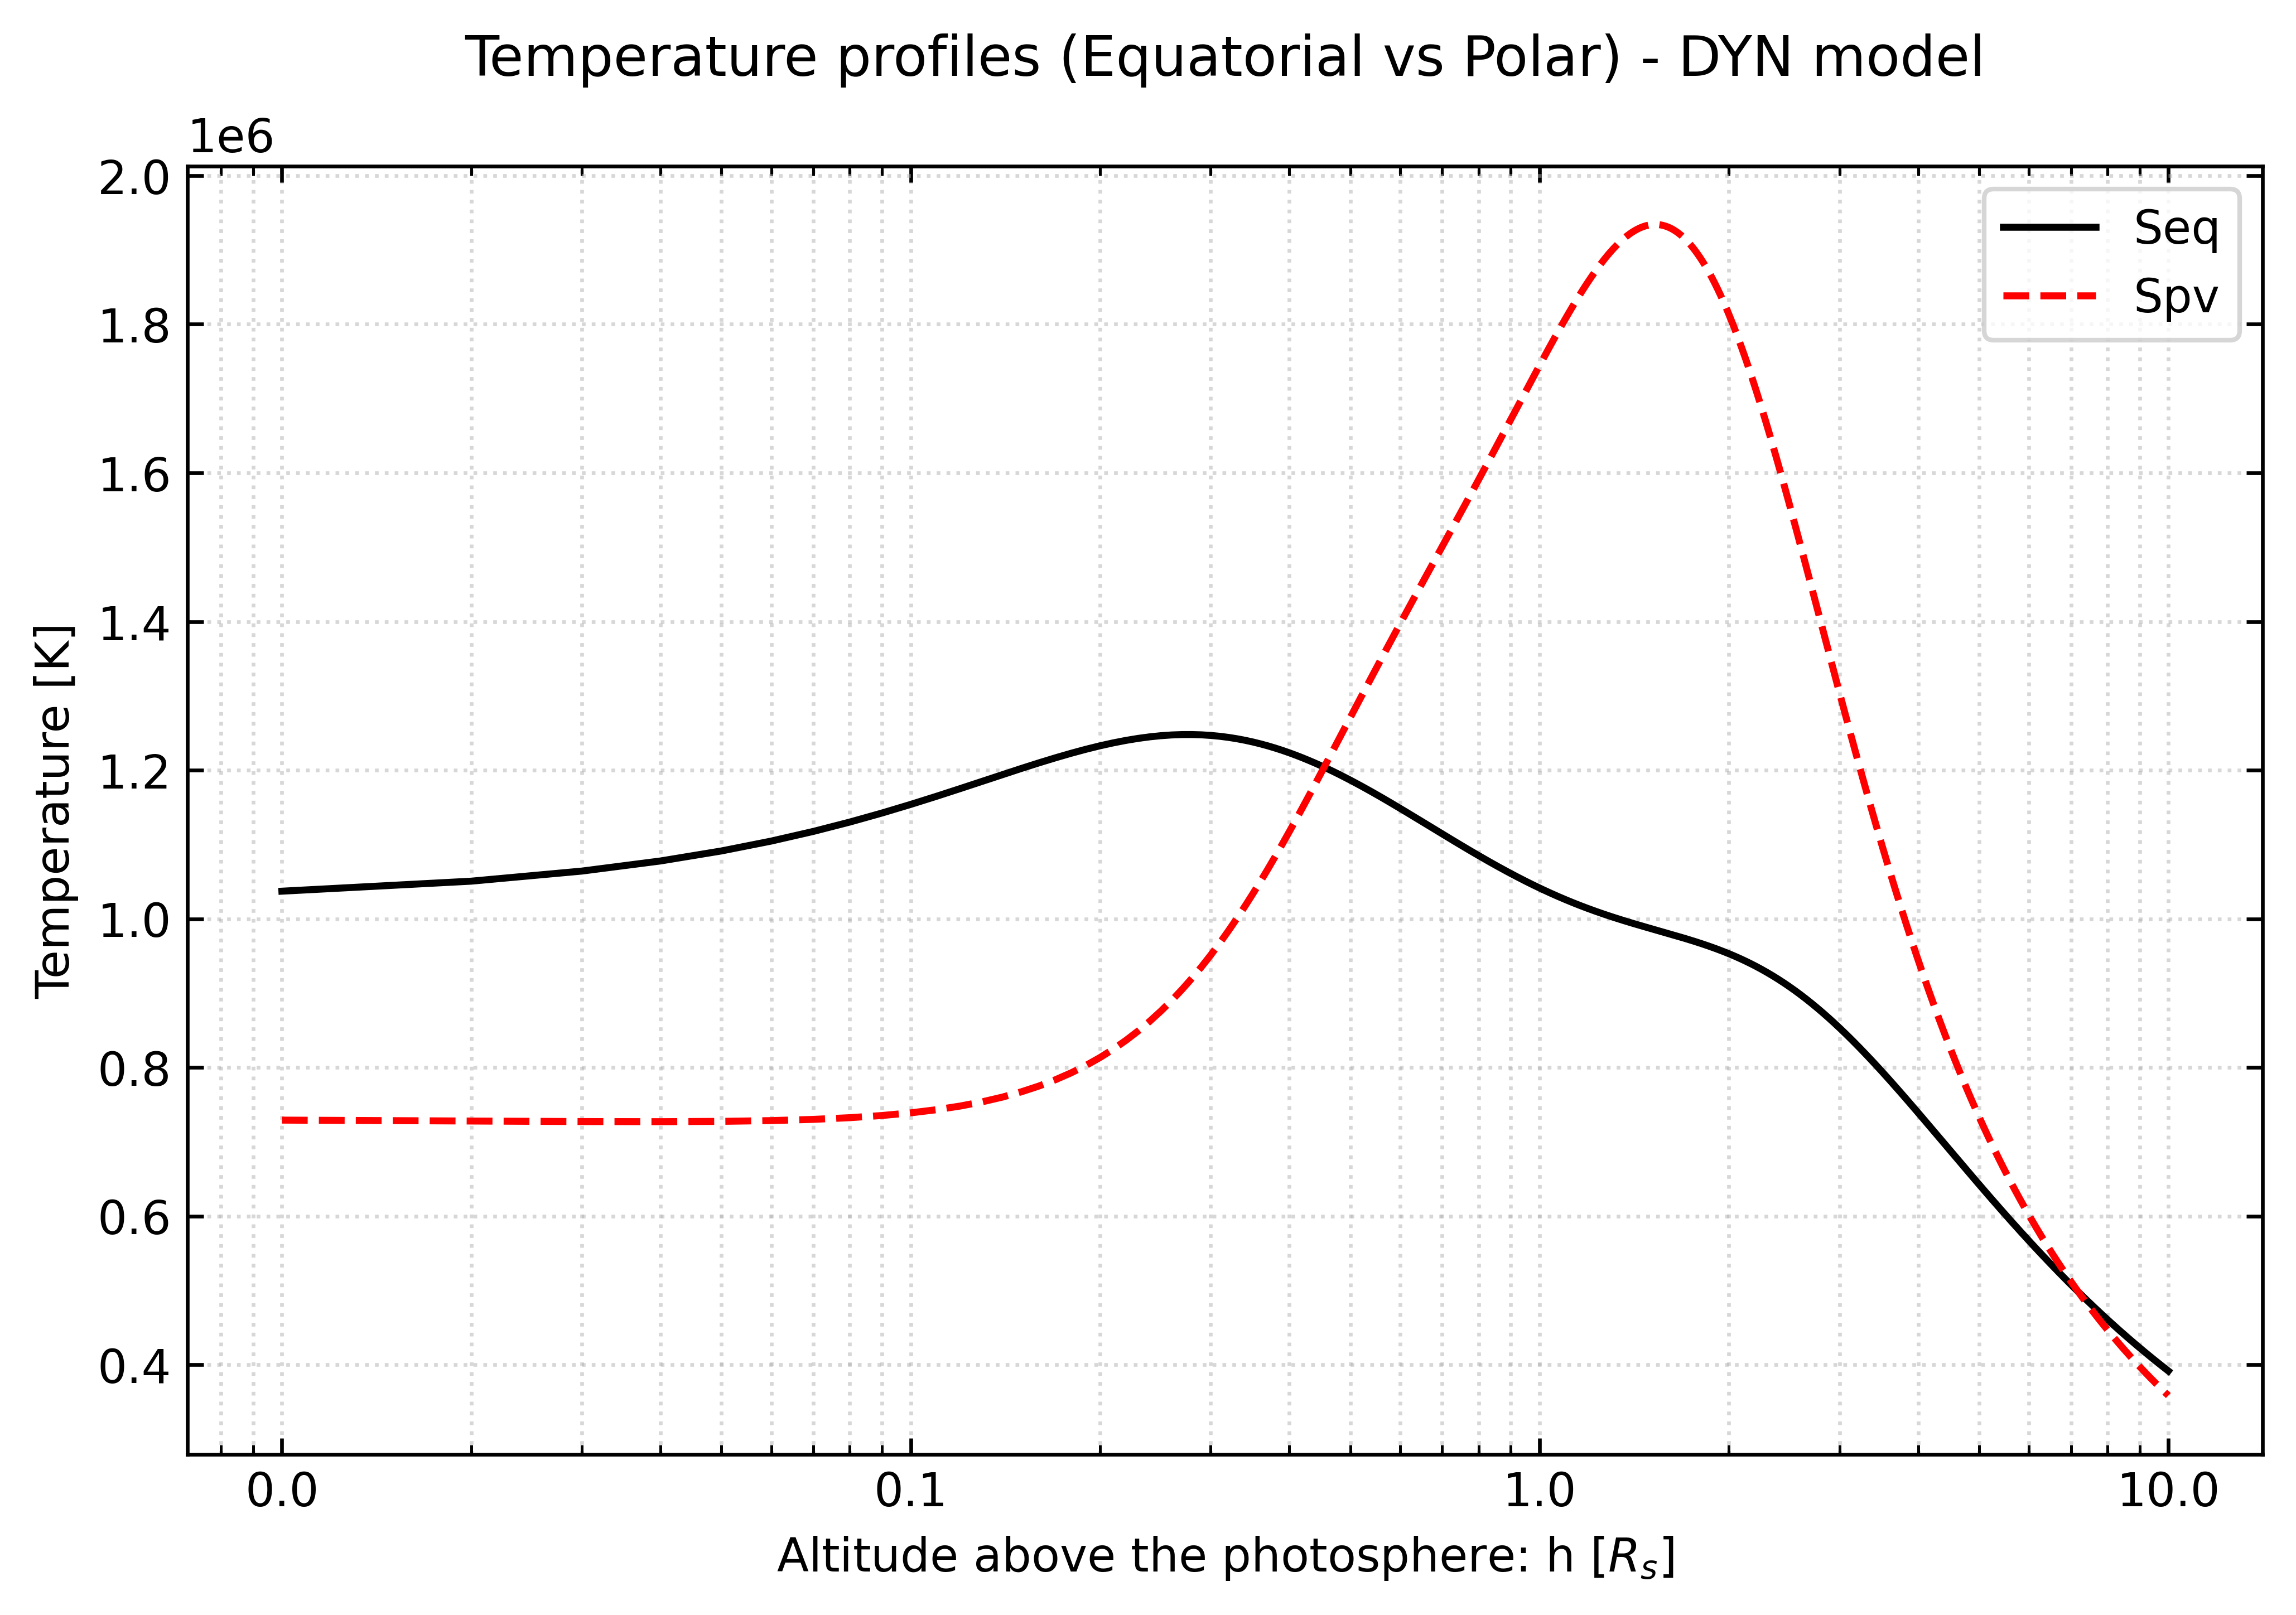

In [19]:
plt.figure(figsize=(8, 5))

# Plot
plt.plot(h_values, T_differentLat[0], "-", label='Seq', color = "black")
plt.plot(h_values, T_differentLat[1], "--", label='Spv', color = "red")

# Cosmetic
plt.title("Temperature profiles (Equatorial vs Polar) - DYN model\n")
plt.xscale("log")
plt.xlabel("Altitude above the photosphere: h [$R_s$]")
plt.ylabel("Temperature [K]")
plt.tick_params(direction="in", which="both", top = "True", right = "True")
plt.grid(True, which="both", linestyle=":", alpha = 0.5)

ax = plt.gca()
ax.xaxis.set_major_formatter(ScalarFormatter())
ax.ticklabel_format(useOffset=False, style='plain', axis='x')

# Legend
plt.legend()
plt.rcParams['figure.dpi'] = 600  # set the image resolution at 600 DPI

---